In [8]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import SimpleITK as sitk
from monai.transforms import (
    Compose,
    Resize,
    SpatialPad,
)
import numpy as np

this_path = Path().resolve()
data_path = this_path.parent.parent / 'acouslic-ai-train-set'
assert data_path.exists()

#### Preprocess images

In [3]:
def plot_img_w_mask(img, mask, slice):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img[slice], cmap='gray')
    ax[0].set_title('Image')
    ax[0].axis('off')
    ax[1].imshow(mask[slice], cmap='gray')
    ax[1].set_title('Mask')
    ax[1].axis('off')
    plt.show()

(840, 562, 744) (840, 562, 744)


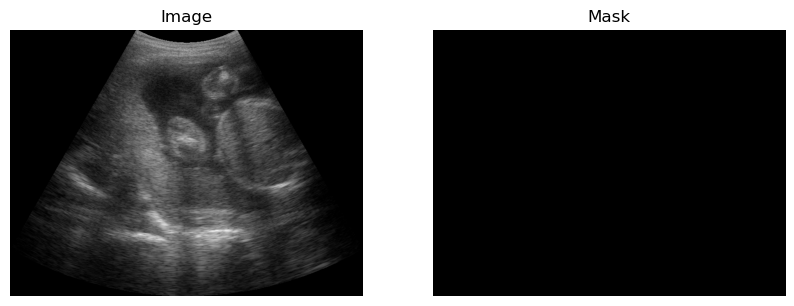

In [11]:
preprocess_image = Compose([
            SpatialPad(spatial_size=[-1, 744, 744],
                       method='symmetric',
                       mode='constant', constant_values=0),
            Resize(spatial_size=[-1, 256, 256], mode='bilinear')
        ])
image_path = data_path / 'images' / 'stacked_fetal_ultrasound' / '0d0a3298-a9c6-43c3-a9e3-df3a9c0afa06.mha'
mask_path = data_path / 'masks' / 'stacked_fetal_abdomen' / '0d0a3298-a9c6-43c3-a9e3-df3a9c0afa06.mha'
image = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
print(image.shape, mask.shape)
plot_img_w_mask(image, mask, 312)

In [12]:
image_pp = preprocess_image(np.asarray(image))
mask_pp = preprocess_image(np.asarray(mask))

RuntimeError: applying transform <monai.transforms.croppad.array.SpatialPad object at 0x7f9d8110fb20>

In [5]:
# read metadata csv
df = pd.read_csv(data_path / 'circumferences/fetal_abdominal_circumferences_per_sweep.csv').fillna(0)
print(len(df)), print(df.subject_id.nunique()), print(df.uuid.nunique())
df.head()

300
281
300


,uuid,subject_id,sweep_1_ac_mm,sweep_2_ac_mm,sweep_3_ac_mm,sweep_4_ac_mm,sweep_5_ac_mm,sweep_6_ac_mm
0,2e99ee0e-506a-443b-8c16-e8a0619da2f7,0,579.217706,0.0,0.0,0.0,0.000000,0.0
1,bfd442e7-9299-4890-ad3d-c9d5b6534cbc,1,0.000000,0.0,0.0,0.0,519.406363,0.0
2,0199616b-bdeb-4119-97a3-a5a3571bd641,2,624.540028,0.0,0.0,0.0,587.598341,0.0
3,dcdcb9a4-fec7-45a2-b2b7-a282f963c551,2,398.869800,0.0,0.0,0.0,0.000000,0.0
4,484c03b0-441d-4966-b10e-06b31d84e55e,3,614.922733,0.0,0.0,0.0,0.000000,0.0


In [6]:
(data_path / 'circumferences/fetal_abdominal_circumferences_per_sweep.csv').parent

PosixPath('/home/alejandro/repos/acouslic-ai-train-set/circumferences')

#### Split

In [3]:
from sklearn.model_selection import train_test_split, KFold
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_n, (train_ids, val_ids) in enumerate(kf.split(df.subject_id.unique())):
    print(train_ids, val_ids)
    print(len(train_ids), len(val_ids))
    break

[  0   1   2   3   4   6   9  10  11  13  14  16  17  18  19  21  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  47  48  49  50  51  52  53  54  56  57  58  60  61  62  65  66
  67  68  69  70  71  72  75  77  78  79  80  81  82  83  84  85  86  87
  88  91  93  94  95  96  98  99 100 102 104 105 107 108 109 111 112 113
 114 115 117 119 120 121 122 123 125 126 127 128 129 130 131 132 133 134
 135 137 138 140 141 142 143 144 145 146 147 148 149 151 152 154 155 156
 158 159 160 162 163 164 165 167 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 185 186 188 189 190 191 192 193 194 195 196 197 198
 199 202 203 204 205 209 210 211 213 215 216 218 220 222 223 224 226 227
 229 231 232 233 234 236 237 238 239 240 241 242 243 244 245 246 249 250
 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 268 269 270
 271 273 274 276 277 278 279 280] [  5   7   8  12  15  20  22  45  46  55  59  63  64  73  74  76  89  90
  92  97 101 103 

#### Others

In [29]:
dup_subid = df.subject_id.duplicated()
df.iloc[dup_subid[dup_subid].index]

,uuid,subject_id,sweep_1_ac_mm,sweep_2_ac_mm,sweep_3_ac_mm,sweep_4_ac_mm,sweep_5_ac_mm,sweep_6_ac_mm
3,dcdcb9a4-fec7-45a2-b2b7-a282f963c551,2,398.869800,0.000000,0.000000,0.000000,0.000000,0.000000
6,d15a282b-25ca-40ab-915c-215335a0d3cf,4,468.869376,0.000000,0.000000,0.000000,0.000000,0.000000
8,6fcb175f-52e4-4f3e-9956-f693b28f56e6,5,539.273230,0.000000,0.000000,0.000000,593.227437,0.000000
11,47540baa-7ab8-425a-9e77-8005cb1c02f4,7,0.000000,0.000000,0.000000,0.000000,0.000000,625.315015
14,f1fcabfc-f998-44c7-8420-c7a5ae5aaab7,9,347.865287,0.000000,0.000000,0.000000,0.000000,0.000000
16,30555893-2ac6-45c9-b404-8ca2d9f90b05,10,0.000000,468.458321,0.000000,0.000000,0.000000,0.000000
18,acac6afb-e374-47a7-8954-d4ed87dd55df,11,462.019562,413.044932,0.000000,0.000000,0.000000,0.000000
48,685ebd4e-483d-4b2f-8e35-d05de68d0cd6,40,581.788537,0.000000,0.000000,0.000000,0.000000,0.000000
111,3bd64075-6e7e-463d-86e1-19071f04327c,102,421.584846,0.000000,0.000000,0.000000,0.000000,0.000000
206,f5a702f0-d759-4b53-8215-462e8145e638,196,285.427803,281.834202,289.114157,0.000000,0.000000,0.000000


In [39]:
for sweep in range(1, 7):
    # print(sweep)
    df[f'sweep_{sweep}_ac_mm'] = df[f'sweep_{sweep}_ac_mm'] > 0

In [40]:
df.head()

,uuid,subject_id,sweep_1_ac_mm,sweep_2_ac_mm,sweep_3_ac_mm,sweep_4_ac_mm,sweep_5_ac_mm,sweep_6_ac_mm
0,2e99ee0e-506a-443b-8c16-e8a0619da2f7,0,True,False,False,False,False,False
1,bfd442e7-9299-4890-ad3d-c9d5b6534cbc,1,False,False,False,False,True,False
2,0199616b-bdeb-4119-97a3-a5a3571bd641,2,True,False,False,False,True,False
3,dcdcb9a4-fec7-45a2-b2b7-a282f963c551,2,True,False,False,False,False,False
4,484c03b0-441d-4966-b10e-06b31d84e55e,3,True,False,False,False,False,False


In [52]:
df.drop(columns=['uuid', 'subject_id']).sum(axis=1).value_counts()

1    127
2    108
3     50
4     15
Name: count, dtype: int64

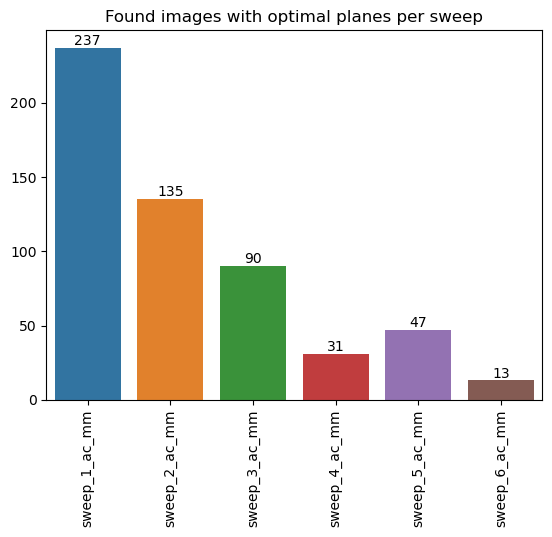

In [49]:
df_to_plot = df.drop(columns=['uuid', 'subject_id']).sum()
ax = sns.barplot(x=df_to_plot.index, y=df_to_plot.values)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=90)
plt.title('Found images with optimal planes per sweep')
plt.show()